In [202]:
chroms = [1]#,'X']
region_idxs = list(range(0,1000,50))
sample_dir = '../../data/samples/'#no_symmetry_32'#small_model_large_embedder/'#small_model/'#'../diffusion_v1/sampling_small/'
milestone = 120
cond_scales = [1,2,4,6,8]#[1.]#[float(k) for k in range(1,6)]
rescaled_phis = [0,.25,.5,.75,1]#[k/10 for k in range(1,11)]
has_symmetry = False 
nbeads=65

In [6]:
import torch 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 

import sys
sys.path.insert(1,'../data_utils/')
from Sample import Sample 
from HiCDataset import HiCDataset
from HiCMap import HiCMap

In [ ]:
emb_fp = lambda chrom: f'/home/gridsan/gschuette/refining_scHiC/revamp_with_zhuohan/data/embeddings/chrom_{chrom}.tar.gz'
embeddings = {}
embeddings_idx = {}
for chrom in chroms: 
    embeddings[chrom] = pd.read_pickle(emb_fp(chrom))
    embeddings_idx[chrom] = embeddings[chrom].index
exp_hic = HiCDataset()

In [44]:
class ComputeSubregion: # This will select the relevant subregions!

    def __init__(self,nbeads,includes_self_interaction):

        self.return_size = nbeads // 2
        shift = int(includes_self_interaction)
        self.includes_self_interaction = includes_self_interaction
        self.start_size = nbeads - 1 + shift
        self.index_for_large_matrix = (
            torch.arange(self.return_size).repeat_interleave(self.return_size), # 0,0,0,...,1,1,1,...,N,N,N
            torch.cat([torch.arange(i,i+self.return_size) for i in range(shift,self.return_size+shift)]) # 1,2,3,...,N+1,2,3,..,N+2,...,N+small_size (if shift=1)
        )
    def __call__(self,full_maps):
        n,i,j = self.return_size, *self.index_for_large_matrix
        return full_maps[...,i,j].unflatten(-1,(n,n))

    def inverse(self,submap):
        N,i,j,optional_dims = self.start_size,*self.index_for_large_matrix,submap.shape[:-2]
        full_shape = (*optional_dims,N,N) 
        full_maps = torch.empty(
            full_shape,
            device=submap.device,
            dtype=submap.dtype
        ).fill_(torch.nan)
        
        full_maps[...,i,j] = full_maps[...,j,i] = submap.flatten(-2) 
        if self.includes_self_interaction: 
            i = torch.arange(N) 
            full_maps[...,i,i] = 0 
        return full_maps

compute_subregion = ComputeSubregion(nbeads,False)#True)

def load_sample(
    directory,
    region_idx,
    cond_scale,
    rescaled_phi,
    milestone,
    chrom,
    has_symmetry=has_symmetry
):
    if directory != '' and directory[-1] != '/':
        directory+= '/'
        
    fp = f'{directory}sample_{region_idx}_{int(cond_scale)}_{int(10*rescaled_phi)}_{milestone}_{chrom}.pkl'
    data = pd.read_pickle(fp).batch
    if not has_symmetry: 
        sample = Sample(data=compute_subregion.inverse(data))
        sample.normalized = True
    else: 
        sample = Sample(data=data)

    return sample

In [8]:
def get_exp_map(region_idx,exp_hic,emb_idx,interp_nans=True): 

    # Get the region information from the embedding index used during sample generation
    region_length, chrom, start = emb_idx[region_idx]
    stop = start + region_length
    
    return exp_hic.fetch(chrom=chrom,start=start,stop=stop,interp_nans=interp_nans)

In [69]:
def tanh_map(sample,r_c,sigma):
    '''
    Avoids using the distance correction approach
    '''
    if sample.normalized: 
        sample.unnormalize_()
    r = sample.batch.clone()

    mask = r < float(r_c)
    r[mask] = .5*( 1 + torch.tanh( sigma*( r_c - r[mask] ) ) )
    mask^= True
    r[mask] = .5 * ( r_c / r[mask] )**4
    
    return HiCMap(r.mean(0).squeeze(),includes_self_interaction=False)

In [111]:
def tanh_map(sample,r_c,sigma):
    '''
    Avoids using the distance correction approach
    '''
    if sample.normalized: 
        sample.unnormalize_()
    r = sample.unflatten() #batch.clone()

    mask1 = r.isfinite()
    mask = r < float(r_c)
    r[mask&mask1] = .5*( 1 + torch.tanh( sigma*( r_c - r[mask&mask1] ) ) )
    mask^= True
    r[mask&mask1] = .5 * ( r_c / r[mask&mask1] )**4
    return HiCMap(r.mean(0).squeeze(),includes_self_interaction=False)

In [116]:
def optimize_r_c_sigma(
    gen_sample,
    exp_probs,
    lr = 0.001,
    n_it = 100,#00,
    loss_tol = 10e-6,
    grad_thresh = .001
): 
    # first guesses
    r_c = torch.tensor(1.75).requires_grad_(True)
    sigma = torch.tensor(4.).requires_grad_(True)

    #exp_probs = exp_probs.to(torch.double)
    #gen_sample.to(torch.double) 
    #gen_sample.batch_dtype = torch.double 

    N = exp_probs.shape[-1]
    i,j = torch.triu_indices(N,N,1)
    def loss_fcn(gen_sample,exp_probs,r_c,sigma):
        gen_map = tanh_map(gen_sample,r_c,sigma)
        #print(f'gen map: {gen_map.prob_map.shape}')
        k = gen_map.prob_map[...,i,j].isfinite()
        return (gen_map.prob_map[...,i,j][k] - exp_probs.prob_map[...,i,j][k]).square().mean()
        #gen_map,mask = tanh_map(gen_sample,r_c,sigma)

    optimizer = torch.optim.Adam([r_c,sigma],lr=lr)

    loss = loss_fcn(gen_sample,exp_probs,r_c,sigma)
    loss.backward()
    n = 0
    while n < n_it and loss > loss_tol and r_c.grad > grad_thresh and sigma.grad > grad_thresh: 
        optimizer.zero_grad()
        loss = loss_fcn(gen_sample,exp_probs,r_c,sigma)
        loss.backward()
        optimizer.step()
        n+=1
    print(f'Final Loss: {loss.detach()}')
    print(f'Final it: {n}')
    return r_c.detach(), sigma.detach()

r_c: 1.75
sigma: 3.5


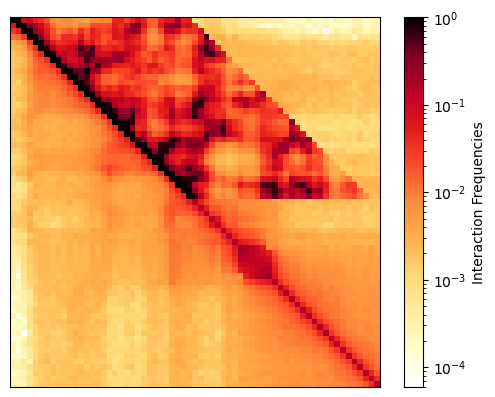

In [206]:
chrom_ = 1
milestone_ = 95#120 
region_idx_ = 50#100
cond_scale_ = 1.
rescaled_phi_ = 0 
sample_dir_ = '/home/gridsan/gschuette/refining_scHiC/revamp_with_zhuohan/data/samples/no_symmetry_32_larger_embedder/'
#sample_dir_ = '/home/gridsan/gschuette/refining_scHiC/revamp_with_zhuohan/data/samples/no_symmetry_32/'

gen_sample = load_sample(
    sample_dir_,
    region_idx_,
    cond_scale_,
    rescaled_phi_,
    milestone_,
    chrom_
)
exp_map = get_exp_map(region_idx_,exp_hic,embeddings_idx[chrom_],interp_nans=True)

#r_c, sigma = optimize_r_c_sigma(gen_sample,exp_map)
r_c, sigma = 1.75, 3.5

hic_map = tanh_map(gen_sample,r_c,sigma)
#i,j = torch.triu_indices(hic_map.shape[-1],hic_map.shape[-1],1)
#hic_map.prob_map[j,i] = exp_map.prob_map[i,j]
#hic_map.plot()
i,j = compute_subregion.index_for_large_matrix
exp_map.prob_map[i,j] = hic_map.prob_map[i,j]
exp_map.plot()
print(f'r_c: {r_c}')
print(f'sigma: {sigma}')

In [207]:
gen_sample.batch.shape

torch.Size([100, 1, 64, 64])

(<Figure size 640x480 with 2 Axes>,
 <Axes: >,
 <matplotlib.colorbar.Colorbar at 0x7efd40eb1690>)

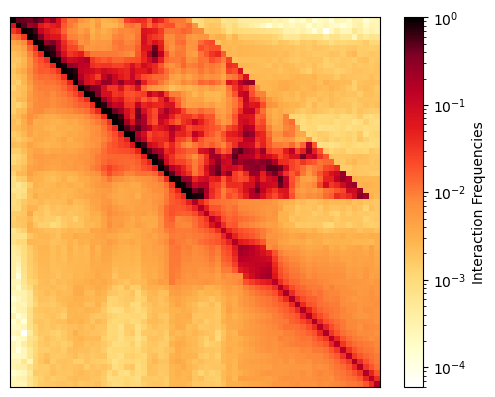

In [204]:
chrom_ = 1
milestone_ = 120 
region_idx_ = 50#200
cond_scale_ = 1.
rescaled_phi_ = 0
#sample_dir_ = '/home/gridsan/gschuette/refining_scHiC/revamp_with_zhuohan/data/samples/no_symmetry_32_larger_embedder/'
sample_dir_ = '/home/gridsan/gschuette/refining_scHiC/revamp_with_zhuohan/data/samples/no_symmetry_32/'

r_c = 1.5
sigma=3.5

sample1 = load_sample(
    sample_dir_,
    region_idx_,
    cond_scale_,
    rescaled_phi_,
    milestone_,
    chrom_
)

'''
exp_map = get_exp_map(region_idx_,exp_hic,embeddings_idx[chrom_],interp_nans=True)
exp_map.plot()

hic_map = tanh_map(sample1,r_c,sigma)
hic_map.plot()

hic_map[]
'''

hic_map = tanh_map(sample1,r_c,sigma)
exp_map = get_exp_map(region_idx_,exp_hic,embeddings_idx[chrom_],interp_nans=True)
#i,j = torch.triu_indices(hic_map.shape[-1],hic_map.shape[-1],1)
#hic_map.prob_map[j,i] = exp_map.prob_map[i,j]
#hic_map.plot()
i,j = compute_subregion.index_for_large_matrix
exp_map.prob_map[i,j] = hic_map.prob_map[i,j]
exp_map.plot()


In [208]:
sample1.batch.shape

torch.Size([500, 1, 64, 64])

r_c: 1.5
sigma: 3.5


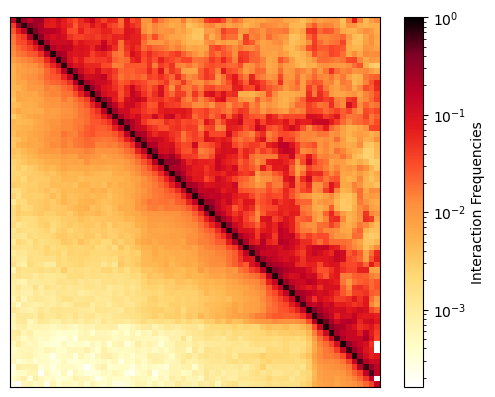

In [182]:
chrom_ = 1
milestone_ = 84#120 
region_idx_ = 0#100
cond_scale_ = 4.
rescaled_phi_ = .7#.7
#sample_dir_ = '/home/gridsan/gschuette/refining_scHiC/revamp_with_zhuohan/data/samples/no_symmetry_32_larger_embedder/'
#sample_dir_ = '/home/gridsan/gschuette/refining_scHiC/revamp_with_zhuohan/data/samples/no_symmetry_32/'
sample_dir_ = '/home/gridsan/gschuette/refining_scHiC/revamp_with_zhuohan/data/samples/small_model_large_embedder'

gen_sample = load_sample(
    sample_dir_,
    region_idx_,
    cond_scale_,
    rescaled_phi_,
    milestone_,
    chrom_,
    True
)
exp_map = get_exp_map(region_idx_,exp_hic,embeddings_idx[chrom_],interp_nans=True)

#r_c, sigma = optimize_r_c_sigma(gen_sample,exp_map)
r_c, sigma = 1.5,3.5

hic_map = tanh_map(gen_sample,r_c,sigma)
#i,j = torch.triu_indices(hic_map.shape[-1],hic_map.shape[-1],1)
#hic_map.prob_map[j,i] = exp_map.prob_map[i,j]
#hic_map.plot()
i,j = torch.triu_indices(hic_map.prob_map.shape[-1],hic_map.prob_map.shape[-1],1)#compute_subregion.index_for_large_matrix
exp_map.prob_map[i,j] = hic_map.prob_map[i,j]
exp_map.plot()
print(f'r_c: {r_c}')
print(f'sigma: {sigma}')

In [147]:
gen_sample.batch[gen_sample.batch.isfinite()].max()

tensor(18.0090, dtype=torch.float64)